# AIE425 Intelligent Recommender Systems, Fall Semester 25/26
Assignment 1: Neighborhood CF & Clustering in CF
| Name | ID | Part |
| ------ | -----| -----|
| Youssef Husseiny | 222101943 | Section 3 |
| Habiba Ahmed | 222100471 | Section 2 |
| Seif Amr Abdelhafez | 222102312 | Section 1 |

In [1]:
import pandas as pd


### 1. Prepare a dataset of at least 100,000 users, ≥ 1000 products, and ≥ 1 million ratings.


In [2]:
r = pd.read_csv(r'..\dataset\ratings.csv')
r.shape

(32000204, 4)

In [3]:
m = pd.read_csv('..\dataset\movies.csv')
m.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print('is it more than 1 million ratings? answer:',r.shape[0]>=1e6)

is it more than 1 million ratings? answer: True


In [5]:
print('is it more than 1000 Products? answer:',m.shape[0]>=1e3)

is it more than 1000 Products? answer: True


In [6]:
m.shape[0]

87585

In [7]:
r.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [8]:
len(r['userId'].unique())

200948

In [9]:
print('is it more than 100,000 users? answer:',len(r['userId'].unique())>=1e5)

is it more than 100,000 users? answer: True


### 2- Preprocess the dataset to adjust the rating on a 1-to-5 scale.

In [10]:
import numpy as np

In [11]:
r['rating'].max()

5.0

In [12]:
r['rating'].min()

0.5

In [13]:
np.ceil(r['rating']).unique()

array([4., 1., 2., 5., 3.])

In [14]:
r['rating_1to5scale'] = np.ceil(r['rating'])

In [15]:
r['rating_1to5scale'].unique()

array([4., 1., 2., 5., 3.])

In [16]:
r.head()

,userId,movieId,rating,timestamp,rating_1to5scale
0,1,17,4.0,944249077,4.0
1,1,25,1.0,944250228,1.0
2,1,29,2.0,943230976,2.0
3,1,30,5.0,944249077,5.0
4,1,32,5.0,943228858,5.0


## 3- Calculate the number of ratings for each user ($n_u$) and save it


In [17]:
nu = r.groupby('userId').size().reset_index(name='num_ratings')
nu

,userId,num_ratings
0,1,141
1,2,52
2,3,147
3,4,27
4,5,33
...,...,...
200943,200944,298
200944,200945,108
200945,200946,23
200946,200947,61


In [18]:
import os
os.makedirs('../Results', exist_ok=True)

In [19]:
nu.to_csv('../Results/num_of_ratings_for_each_user.csv', index=False)

## 4- Calculate the number of ratings for each item ($n_i$) and save it.

In [20]:
ni = r.groupby('movieId').size().reset_index(name='num_ratings')
ni

,movieId,num_ratings
0,1,68997
1,2,28904
2,3,13134
3,4,2806
4,5,13154
...,...,...
84427,292731,1
84428,292737,1
84429,292753,1
84430,292755,1


In [21]:
m['movieId'].nunique() is ni.shape[0]

False

In [22]:
# I used AI here to write the code that find the movies with no ratings (i know the logic is to see which movies is in the dataset of the movies and not in the ratings dataset) but i used ai here to apply that logic in code
has_no_rating = m.merge(ni, on='movieId', how='left')
has_no_rating = has_no_rating[has_no_rating['num_ratings'].isna()]['movieId']

In [23]:
has_no_rating

11558     52696
12175     58209
13517     69864
13581     70312
13776     71355
          ...  
86109    287561
86360    288447
86753    289697
87391    291509
87578    292629
Name: movieId, Length: 3153, dtype: int64

In [24]:
ni = ni.merge(has_no_rating, on='movieId', how='outer')

In [25]:
ni

,movieId,num_ratings
0,1,68997.0
1,2,28904.0
2,3,13134.0
3,4,2806.0
4,5,13154.0
...,...,...
87580,292731,1.0
87581,292737,1.0
87582,292753,1.0
87583,292755,1.0


In [26]:
ni.isna().sum()

movieId           0
num_ratings    3153
dtype: int64

In [27]:
ni.replace({'num_ratings': {np.nan: 0}}, inplace=True)
ni

,movieId,num_ratings
0,1,68997.0
1,2,28904.0
2,3,13134.0
3,4,2806.0
4,5,13154.0
...,...,...
87580,292731,1.0
87581,292737,1.0
87582,292753,1.0
87583,292755,1.0


In [28]:
ni.isna().sum()

movieId        0
num_ratings    0
dtype: int64

In [29]:
ni.to_csv('../Results/num_of_ratings_for_each_movie.csv', index=False)

## 5- Compute the average ratings per user ($\bar r_u$) in your dataset and save it.


In [30]:
r

,userId,movieId,rating,timestamp,rating_1to5scale
0,1,17,4.0,944249077,4.0
1,1,25,1.0,944250228,1.0
2,1,29,2.0,943230976,2.0
3,1,30,5.0,944249077,5.0
4,1,32,5.0,943228858,5.0
...,...,...,...,...,...
32000199,200948,79702,4.5,1294412589,5.0
32000200,200948,79796,1.0,1287216292,1.0
32000201,200948,80350,0.5,1294412671,1.0
32000202,200948,80463,3.5,1350423800,4.0


In [31]:
average_ratings_per_user = r.groupby('userId')['rating_1to5scale'].mean().reset_index(name='average_rating')

In [32]:
average_ratings_per_user

,userId,average_rating
0,1,3.531915
1,2,4.269231
2,3,3.687075
3,4,2.629630
4,5,3.272727
...,...,...
200943,200944,4.117450
200944,200945,3.287037
200945,200946,4.391304
200946,200947,4.163934


In [33]:
average_ratings_per_user.to_csv('../Results/average_rating_per_user.csv', index=False)

## 6- Compute the average ratings per item ($\bar r_i$) in your datasct and save it.

In [34]:
average_ratings_per_item = r.groupby('movieId')['rating_1to5scale'].mean().reset_index(name='average_rating')

In [35]:
average_ratings_per_item.to_csv('../Results/average_rating_per_item.csv', index=False)

## 7- Ascendingly order the total number of ratings per item and plot the distribution per item.


In [36]:
ni

,movieId,num_ratings
0,1,68997.0
1,2,28904.0
2,3,13134.0
3,4,2806.0
4,5,13154.0
...,...,...
87580,292731,1.0
87581,292737,1.0
87582,292753,1.0
87583,292755,1.0


In [37]:
sorted_ni = ni.sort_values(by='num_ratings', ascending=True)
sorted_ni

,movieId,num_ratings
33301,142310,0.0
32930,141507,0.0
32923,141489,0.0
32917,141476,0.0
51237,181477,0.0
...,...,...
585,593,90330.0
2480,2571,93808.0
292,296,98409.0
351,356,100296.0


In [38]:
import matplotlib.pyplot as plt

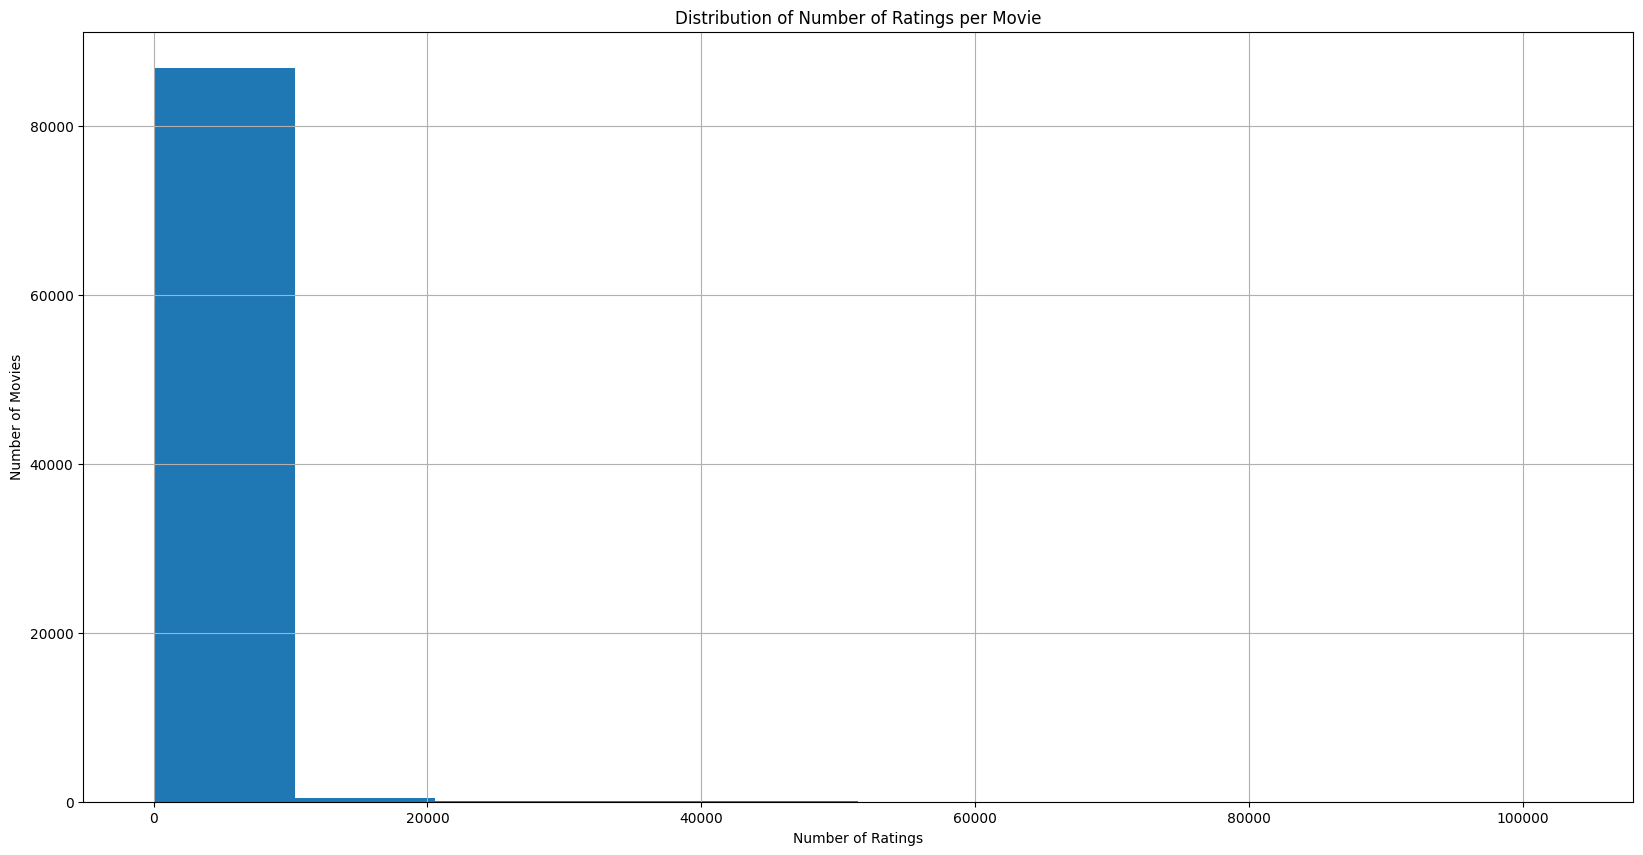

In [39]:
plt.figure(figsize=(20,10))
sorted_ni['num_ratings'].hist()
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Distribution of Number of Ratings per Movie')
plt.savefig('../Results/num_of_ratings_per_movie_distribution.png')
plt.show()

## 8- Compute the number of products based on their average ratings such that G1 is a group of products whose average ratings per product ≤ 1%, 1%<G2≤5%, 5%<G3≤10%, 10%<G4≤20%, 20%<G5≤30%, 30%<G6≤40%, 40%<G7≤50%, 50<G8≤60%, 60%<G9≤70%, 70<G10≤100%.


In [40]:
ni

,movieId,num_ratings
0,1,68997.0
1,2,28904.0
2,3,13134.0
3,4,2806.0
4,5,13154.0
...,...,...
87580,292731,1.0
87581,292737,1.0
87582,292753,1.0
87583,292755,1.0


In [41]:
average_ratings_per_item


,movieId,average_rating
0,1,4.016320
1,2,3.407591
2,3,3.208543
3,4,2.887028
4,5,3.134484
...,...,...
84427,292731,4.000000
84428,292737,2.000000
84429,292753,4.000000
84430,292755,1.000000


In [42]:
item_data = average_ratings_per_item.merge(ni, on='movieId')

In [43]:
item_data_sorted = item_data.sort_values(by='average_rating', ascending=True).reset_index(drop=True)

In [44]:
total_products = len(item_data_sorted)

In [45]:
item_data_sorted

,movieId,average_rating,num_ratings
0,203146,1.0,3.0
1,230591,1.0,1.0
2,284075,1.0,1.0
3,163891,1.0,1.0
4,202539,1.0,2.0
...,...,...,...
84427,282073,5.0,1.0
84428,133297,5.0,2.0
84429,282081,5.0,1.0
84430,256747,5.0,1.0


In [46]:
indices = [
    int(0.01 * total_products), int(0.05 * total_products), int(0.10 * total_products),
    int(0.20 * total_products), int(0.30 * total_products), int(0.40 * total_products),
    int(0.50 * total_products), int(0.60 * total_products), int(0.70 * total_products)
]

In [47]:
indices

[844, 4221, 8443, 16886, 25329, 33772, 42216, 50659, 59102]

In [48]:
groups = {
    'G1': item_data_sorted.iloc[0:indices[0]],
    'G2': item_data_sorted.iloc[indices[0]:indices[1]],
    'G3': item_data_sorted.iloc[indices[1]:indices[2]],
    'G4': item_data_sorted.iloc[indices[2]:indices[3]],
    'G5': item_data_sorted.iloc[indices[3]:indices[4]],
    'G6': item_data_sorted.iloc[indices[4]:indices[5]],
    'G7': item_data_sorted.iloc[indices[5]:indices[6]],
    'G8': item_data_sorted.iloc[indices[6]:indices[7]],
    'G9': item_data_sorted.iloc[indices[7]:indices[8]],
    'G10': item_data_sorted.iloc[indices[8]:]
}

In [49]:
groups

{'G1':      movieId  average_rating  num_ratings
 0     203146             1.0          3.0
 1     230591             1.0          1.0
 2     284075             1.0          1.0
 3     163891             1.0          1.0
 4     202539             1.0          2.0
 ..       ...             ...          ...
 839   159869             1.0          1.0
 840   217775             1.0          1.0
 841   261541             1.0          1.0
 842   276807             1.0          1.0
 843   276877             1.0          1.0
 
 [844 rows x 3 columns],
 'G2':       movieId  average_rating  num_ratings
 844    291222        1.000000          1.0
 845    159951        1.000000          1.0
 846    159955        1.000000          1.0
 847    232601        1.000000          1.0
 848    159960        1.000000          1.0
 ...       ...             ...          ...
 4216   145056        1.947368         19.0
 4217     2462        1.947853        652.0
 4218   146270        1.950000         20.0
 4219

In [50]:
for g, data in groups.items():
    print(f"{g}: {len(data)} products")

G1: 844 products
G2: 3377 products
G3: 4222 products
G4: 8443 products
G5: 8443 products
G6: 8443 products
G7: 8444 products
G8: 8443 products
G9: 8443 products
G10: 25330 products


In [51]:
for group_name, group_data in groups.items():
    os.makedirs('../Results/Section1Task8Results', exist_ok=True)
    group_data.to_csv(f'../Results/Section1Task8Results/{group_name}_products.csv', index=False)

## 9- Compute the total number of ratings in each group and order them ascendingly.


In [52]:
group_ratings_sum = {g: data['num_ratings'].sum() for g, data in groups.items()}
group_ratings_sum

{'G1': 992.0,
 'G2': 49620.0,
 'G3': 22367.0,
 'G4': 854450.0,
 'G5': 1739280.0,
 'G6': 26388.0,
 'G7': 3139959.0,
 'G8': 3489095.0,
 'G9': 3682556.0,
 'G10': 18995497.0}

In [53]:
# i will write the code that is sorting them
sorted_group_ratings = dict(sorted(group_ratings_sum.items(), key=lambda item: item[1]))
sorted_group_ratings

{'G1': 992.0,
 'G3': 22367.0,
 'G6': 26388.0,
 'G2': 49620.0,
 'G4': 854450.0,
 'G5': 1739280.0,
 'G7': 3139959.0,
 'G8': 3489095.0,
 'G9': 3682556.0,
 'G10': 18995497.0}

## 10- Plot the distribution of the number of ratings in each group before and after ordering.


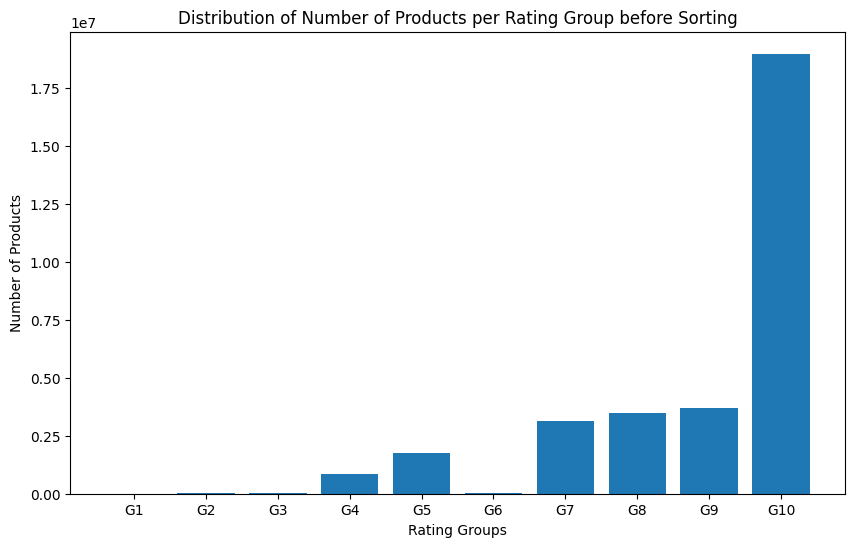

In [54]:
plt.figure(figsize=(10,6))
plt.bar(group_ratings_sum.keys(), group_ratings_sum.values())
plt.xlabel('Rating Groups')
plt.ylabel('Number of Products')
plt.title('Distribution of Number of Products per Rating Group before Sorting')
plt.savefig('../Results/num_of_products_per_rating_group_before_sorting.png')
plt.show()


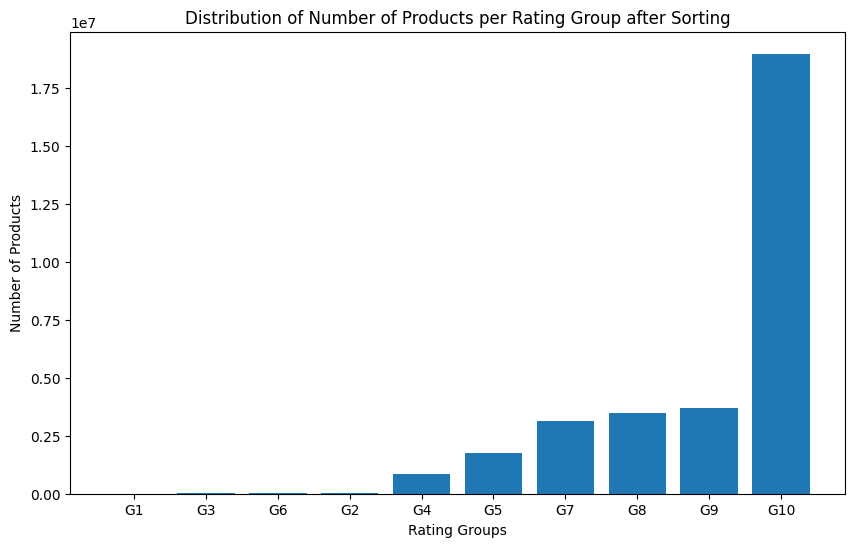

In [55]:
plt.figure(figsize=(10,6))
plt.bar(sorted_group_ratings.keys(), sorted_group_ratings.values())
plt.xlabel('Rating Groups')
plt.ylabel('Number of Products')
plt.title('Distribution of Number of Products per Rating Group after Sorting')
plt.savefig('../Results/num_of_products_per_rating_group_after_sorting.png')
plt.show()

## 11- Select three target users:
- U1 with ≤ 2% ratings
- U2 with ratings >2% and ≤5%
- U3 with ratings >5% and ≤10%


In [56]:
nu

,userId,num_ratings
0,1,141
1,2,52
2,3,147
3,4,27
4,5,33
...,...,...
200943,200944,298
200944,200945,108
200945,200946,23
200946,200947,61


In [57]:
nu_sorted = nu.sort_values(by='num_ratings', ascending=True).reset_index(drop=True)
nu_sorted

,userId,num_ratings
0,162321,20
1,66533,20
2,118980,20
3,118982,20
4,118986,20
...,...,...
200943,171795,9016
200944,123465,9044
200945,55653,9178
200946,17035,9577


In [58]:
total_users = len(nu_sorted)
total_users

200948

In [59]:
target_user1 = nu_sorted.iloc[int(0.02 * total_users)]['userId']
target_user2 = nu_sorted.iloc[int(0.05 * total_users)]['userId']
target_user3 = nu_sorted.iloc[int(0.1 * total_users)]['userId']
target_user1, target_user2, target_user3

(79060, 183483, 55243)

In [60]:
target_users = [target_user1, target_user2, target_user3]
target_users

[79060, 183483, 55243]

In [61]:
print(f"Target Users Selected: {target_users}")
print(f"Number of ratings for U1 ({target_user1}): {nu_sorted.iloc[int(0.02 * total_users)]['num_ratings']}")
print(f"Number of ratings for U2 ({target_user2}): { nu_sorted.iloc[int(0.05 * total_users)]['num_ratings']}")
print(f"Number of ratings for U3 ({target_user3}): {nu_sorted.iloc[int(0.1 * total_users)]['num_ratings']}")

Target Users Selected: [79060, 183483, 55243]
Number of ratings for U1 (79060): 20
Number of ratings for U2 (183483): 22
Number of ratings for U3 (55243): 25


## 12- Select two target items:
- Select the two lowest rated items (11 and I2) as target items


In [62]:
sorted_avg_items = average_ratings_per_item.sort_values(by='average_rating', ascending=True)

In [63]:
sorted_avg_items

,movieId,average_rating
58983,203146,1.0
68876,230591,1.0
82027,284075,1.0
41025,163891,1.0
58737,202539,1.0
...,...,...
81271,282073,5.0
28520,133297,5.0
81273,282081,5.0
74230,256747,5.0


In [64]:
target_item_1 = sorted_avg_items.iloc[0]['movieId']
target_item_2 = sorted_avg_items.iloc[1]['movieId']
target_item_1, target_item_2

(203146.0, 230591.0)

In [65]:
target_items = [target_item_1, target_item_2]
target_items

[203146.0, 230591.0]

In [66]:
with open('../Results/target_items.txt', 'w') as f:
    for item in target_items:
        f.write(f"{item}\n")

In [72]:
print(f"Target Items Selected: {target_items}")
print(f"Avg Rating I1: {sorted_avg_items.iloc[0]['average_rating']}")
print(f"Avg Rating I2: {sorted_avg_items.iloc[1]['average_rating']}")

Target Items Selected: [203146.0, 230591.0]
Avg Rating I1: 1.0
Avg Rating I2: 1.0


## 13- Count the number of co-rating users between each target user and other users (No_common_users), and the number of co-rated items between each target item and other items (No_coRated_items).


In [73]:
analysis_results = {}

for uid in target_users:
    items_rated_by_user = r[r['userId'] == uid]['movieId'].unique()
    common_ratings = r[r['movieId'].isin(items_rated_by_user)]
    co_rating_users_count = common_ratings['userId'].nunique() - 1  # Exclude the target user

    analysis_results[uid] = {
        'items_rated_count': len(items_rated_by_user),
        'common_ratings_df': common_ratings,
        'co_rating_users_count': co_rating_users_count
    }
    print(f"User {uid} has {co_rating_users_count} co-rating users.")
    

User 79060 has 144057 co-rating users.
User 183483 has 71259 co-rating users.
User 55243 has 181410 co-rating users.


In [74]:
analysis_results

{79060: {'items_rated_count': 20,
  'common_ratings_df':           userId  movieId  rating   timestamp  rating_1to5scale
  9              1      111     5.0   944249008               5.0
  26             1      608     2.0   944248943               2.0
  28             1      800     4.0   944248888               4.0
  88             1     1721     5.0   944250182               5.0
  115            1     2329     5.0   944253272               5.0
  ...          ...      ...     ...         ...               ...
  32000039  200948     1721     4.5  1203426099               5.0
  32000053  200948     2396     2.5  1203438477               3.0
  32000066  200948     2710     4.0  1350423730               4.0
  32000067  200948     2712     2.5  1203427940               3.0
  32000070  200948     2858     5.0  1203426352               5.0
  
  [529744 rows x 5 columns],
  'co_rating_users_count': 144057},
 183483: {'items_rated_count': 22,
  'common_ratings_df':           userId  movieId  

In [75]:
for iid in target_items:
    users_who_rated_item = r[r['movieId'] == iid]['userId'].unique()
    common_users = r[r['userId'].isin(users_who_rated_item)]
    co_rated_items_count = common_users['movieId'].nunique() - 1

    print(f"Item {iid} has {co_rated_items_count} co-rated items.")

Item 203146.0 has 6029 co-rated items.
Item 230591.0 has 106 co-rated items.


## 14- Determine the threshold B: maximum number of users who have co-rated at least 30% of items with each target user.


In [76]:
analysis_results[79060].keys()

dict_keys(['items_rated_count', 'common_ratings_df', 'co_rating_users_count'])

In [77]:
beta_results = []

for uid in target_users:
    common_ratings = analysis_results[uid]['common_ratings_df']
    items_rated_count = analysis_results[uid]['items_rated_count']
    
    shared_counts = common_ratings.groupby('userId')['movieId'].nunique()
    
    cuttoff_30_percent = max(1, int(np.ceil(0.3 * items_rated_count)))
    
    qualified_users = shared_counts[shared_counts >= cuttoff_30_percent]
    beta = len(qualified_users)
    if uid in qualified_users.index:
        beta -= 1

    beta_results.append({'UserId': int(uid), 'Total_Items': int(items_rated_count), 'Beta_Threshold': int(beta)})

In [78]:
beta_results

[{'UserId': 79060, 'Total_Items': 20, 'Beta_Threshold': 31844},
 {'UserId': 183483, 'Total_Items': 22, 'Beta_Threshold': 9614},
 {'UserId': 55243, 'Total_Items': 25, 'Beta_Threshold': 64319}]

In [79]:
beta_df = pd.DataFrame(beta_results)
beta_df

,UserId,Total_Items,Beta_Threshold
0,79060,20,31844
1,183483,22,9614
2,55243,25,64319


## 15- Save all intermediate results for use in later parts.


In [80]:
# save target users to a file
with open('../Results/target_users.txt', 'w') as f:
    for user in target_users:
        f.write(f"{user}\n")

In [82]:
beta_df.to_csv('../Results/beta_threshold_results.csv', index=False)
groups_list = [{'Group': k, 'Total_Ratings': v} for k, v in sorted_group_ratings.items()]
pd.DataFrame(groups_list).to_csv('../Results/sorted_groups_total_counts.csv', index=False)

## 16- Compare the results from point 13 & 14 and give your insights into the dataset by evaluating and discussing the matrix sparsity, rating bias and long-tail problems. Give your comments in a separate section in your report.

In [83]:
for iid in target_items:
    users_who_rated_item = r[r['movieId'] == iid]['userId'].unique()
    common_users = r[r['userId'].isin(users_who_rated_item)]
    co_rated_items_count = common_users['movieId'].nunique() - 1

    print(f"Item {iid} has {co_rated_items_count} co-rated items.")

Item 203146.0 has 6029 co-rated items.
Item 230591.0 has 106 co-rated items.


In [84]:
analysis_results

{79060: {'items_rated_count': 20,
  'common_ratings_df':           userId  movieId  rating   timestamp  rating_1to5scale
  9              1      111     5.0   944249008               5.0
  26             1      608     2.0   944248943               2.0
  28             1      800     4.0   944248888               4.0
  88             1     1721     5.0   944250182               5.0
  115            1     2329     5.0   944253272               5.0
  ...          ...      ...     ...         ...               ...
  32000039  200948     1721     4.5  1203426099               5.0
  32000053  200948     2396     2.5  1203438477               3.0
  32000066  200948     2710     4.0  1350423730               4.0
  32000067  200948     2712     2.5  1203427940               3.0
  32000070  200948     2858     5.0  1203426352               5.0
  
  [529744 rows x 5 columns],
  'co_rating_users_count': 144057},
 183483: {'items_rated_count': 22,
  'common_ratings_df':           userId  movieId  

In [85]:
beta_results

[{'UserId': 79060, 'Total_Items': 20, 'Beta_Threshold': 31844},
 {'UserId': 183483, 'Total_Items': 22, 'Beta_Threshold': 9614},
 {'UserId': 55243, 'Total_Items': 25, 'Beta_Threshold': 64319}]

In [86]:
beta_df

,UserId,Total_Items,Beta_Threshold
0,79060,20,31844
1,183483,22,9614
2,55243,25,64319
